<a href="https://colab.research.google.com/github/patrick-zvenyika/ml-projects/blob/main/Type_2_Diabetes_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diabetes Prediction Model using Pima Indians Dataset**

In [65]:
# Importing dependencies

In [66]:
# Classic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Advanced Visualization Libraries
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True) #enables plotly plots to be displayed in notebook
cmap1 = "gist_gray"

#Models
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

#Metrics, Preprocessing and Tuning Tools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
#from sklearn.metrics import plot_
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import missingno as msno
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#Customization
import warnings
warnings.filterwarnings("ignore")
from termcolor import colored

Data Analysis

In [67]:
data = pd.read_csv('/content/diabetes.csv')

In [68]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [69]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [70]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [71]:
data.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [72]:
def check_data(data):
    print(80 * "*")
    print('DIMENSION: ({}, {})'.format(data.shape[0], data.shape[1]))
    print(80 * "*")
    print("COLUMNS:\n")
    print(data.columns.values)
    print(80 * "*")
    print("DATA INFO:\n")
    print(data.dtypes)
    print(80 * "*")
    print("MISSING VALUES:\n")
    print(data.isnull().sum())
    print(80 * "*")
    print("NUMBER OF UNIQUE VALUES:\n")
    print(data.nunique())

check_data(data)

********************************************************************************
DIMENSION: (768, 9)
********************************************************************************
COLUMNS:

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age' 'Outcome']
********************************************************************************
DATA INFO:

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
********************************************************************************
MISSING VALUES:

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI        

In [73]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(" RESULT ".center(50, "-"))
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print("".center(50, "-"))

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(data)

--------------------- RESULT ---------------------
Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
--------------------------------------------------


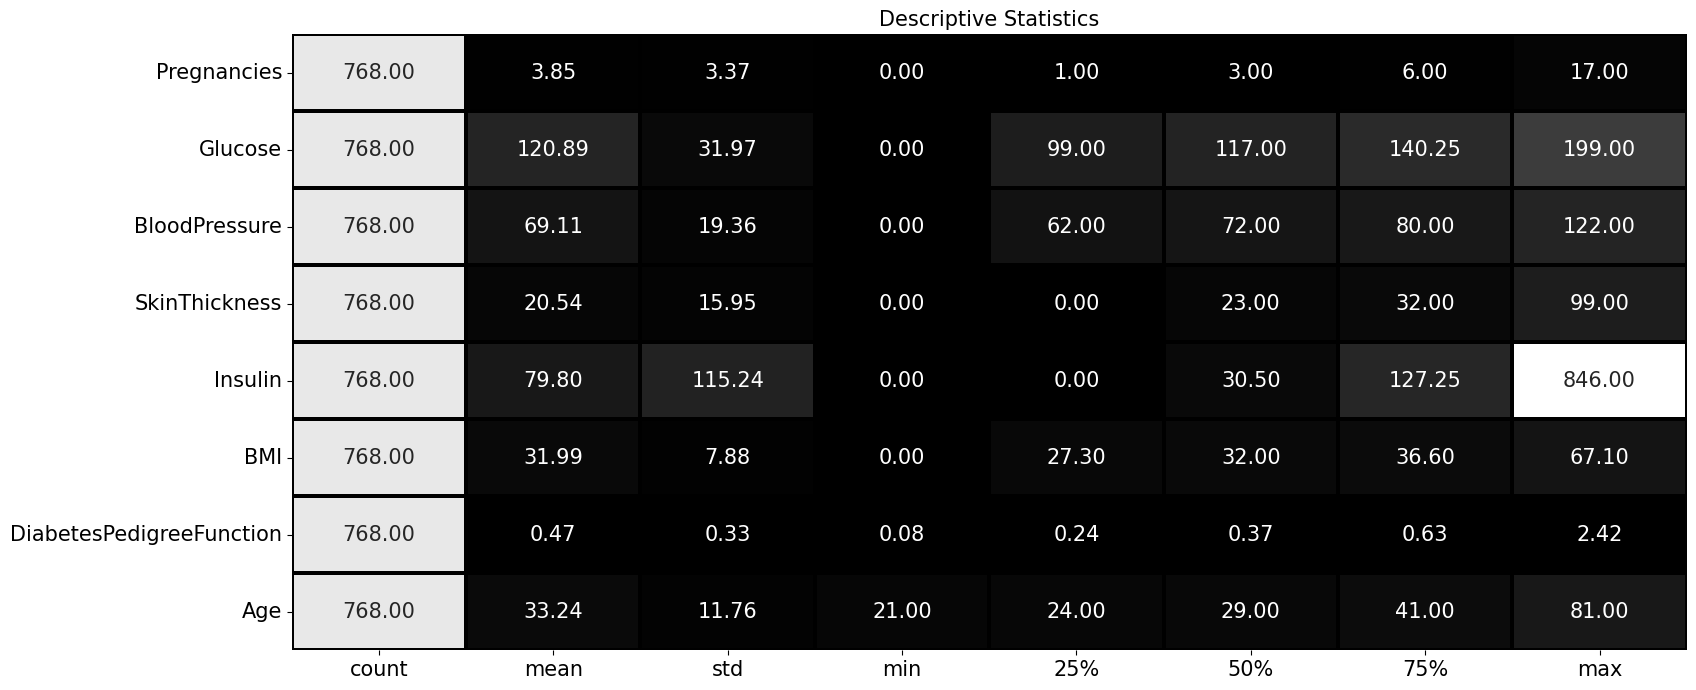

In [74]:
def descriptive_stats(data):
    desc = data.describe().T
    desc_df = pd.DataFrame(index = data. columns,
                          columns = desc.columns,
                          data = desc)
    f, ax = plt.subplots(figsize = (18, 8))
    sns.heatmap(desc,
               annot = True,
               cmap = cmap1,
               fmt = ".2f",
               ax = ax,
               linecolor = "black",
               linewidths = 1.5,
               cbar = False,
               annot_kws = {"size" : 15})
    plt.xticks(size = 15)
    plt.yticks(size = 15, rotation = 0)
    plt.title("Descriptive Statistics", size = 15)
    plt.show()


descriptive_stats(data[num_cols])

**Summary of the Dataset**

* The dataset consists of 768 rows and 8 columns.

* The target variable is Outcome, which contains categorical binary values 0 and 1.

* The variables other than Outcome are numerical.

* There are technically no missing values because of lack NaN values, however when we examine closely, some 0's in the dataset indicate they are actually missing values

* Descriptive statistics show that some features may have outliers (for example, 17 pregnancies can be an outlier).

**Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) is an approach to get significant information and discover patterns hidden in the dataset by using visualization methods. It includes univariate, bivariate and multivariate analysis for numerical and categorical features.

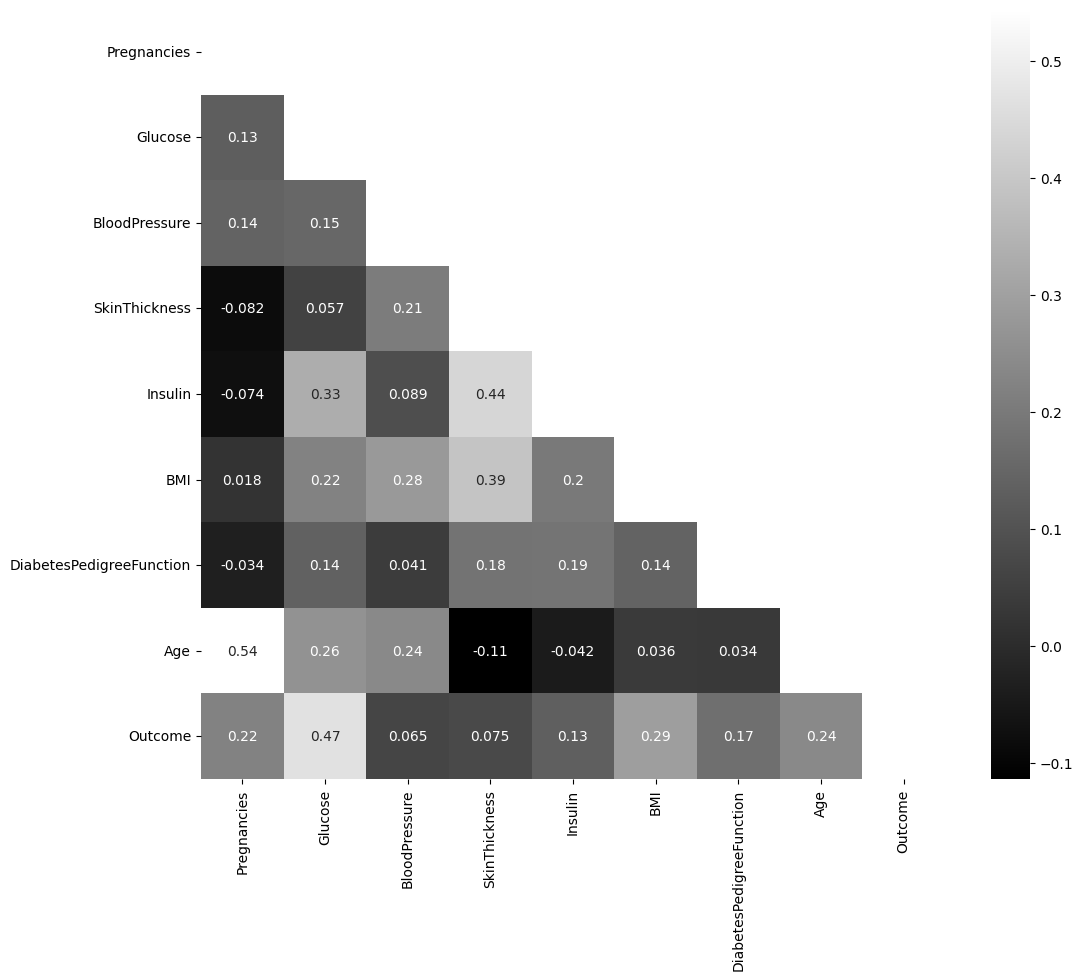

In [75]:
def df_corr(data):
    plt.figure(figsize = (12,10))
    corr = data.corr()
    matrix = np.triu(corr)
    sns.heatmap(corr, annot = True, mask = matrix, cmap = "gist_gray")

df_corr(data)

**Observations from Exploratory Data Analysis**

* There are no highly correlated independent variables.

* The presence of outliers that can affect the models draw attention.

* Despite the fact that some values like Glucose, BMI etc. that can't have the value 0, we see that these features contain 0's. So, we should handle them in the feature engineering step.

**Data Preprocessing**

* This step will include filling missing values, outlier detection and removal, feature engineering, scaling and splitting data.

* As you know, missing values and outliers have always the potential to directly affect the model. Since this may lead to undesired consequences, we should handle them in a correct way.

* Even though there are many methods all of which are useful to some degree case by case, a common approach to handle missing values is filling them with unbiased statistics like mode, mean or median. Because removal of them means loss of information and imputation methods bring the possibility of changing the distribution of features.

* As for outliers, the initial action is to detect them. Then we need to examine them carefully and determine if they affect the model or not. Analysts generally tend to keep them in the dataset, because removing them can lead to loss of information, which is an awful thing for the accuracy of models. However, if they contain extreme values, then removal of the outliers can be taken into account.

* After these processes comes the feature engineering. This step is the key of a successful model.

* As you can guess, raw data lack enough information or are bloated with irrelevant variables on most occasions. We should feel the urge to fix these issues whenever we see them in our projects and the way to do so is feature engineering. Selecting the relevant features or creating the new ones always increase the accuracy of models.

* And after everythings is done, don't forget to scale your data and split it into two groups as test and train data.

<Axes: >

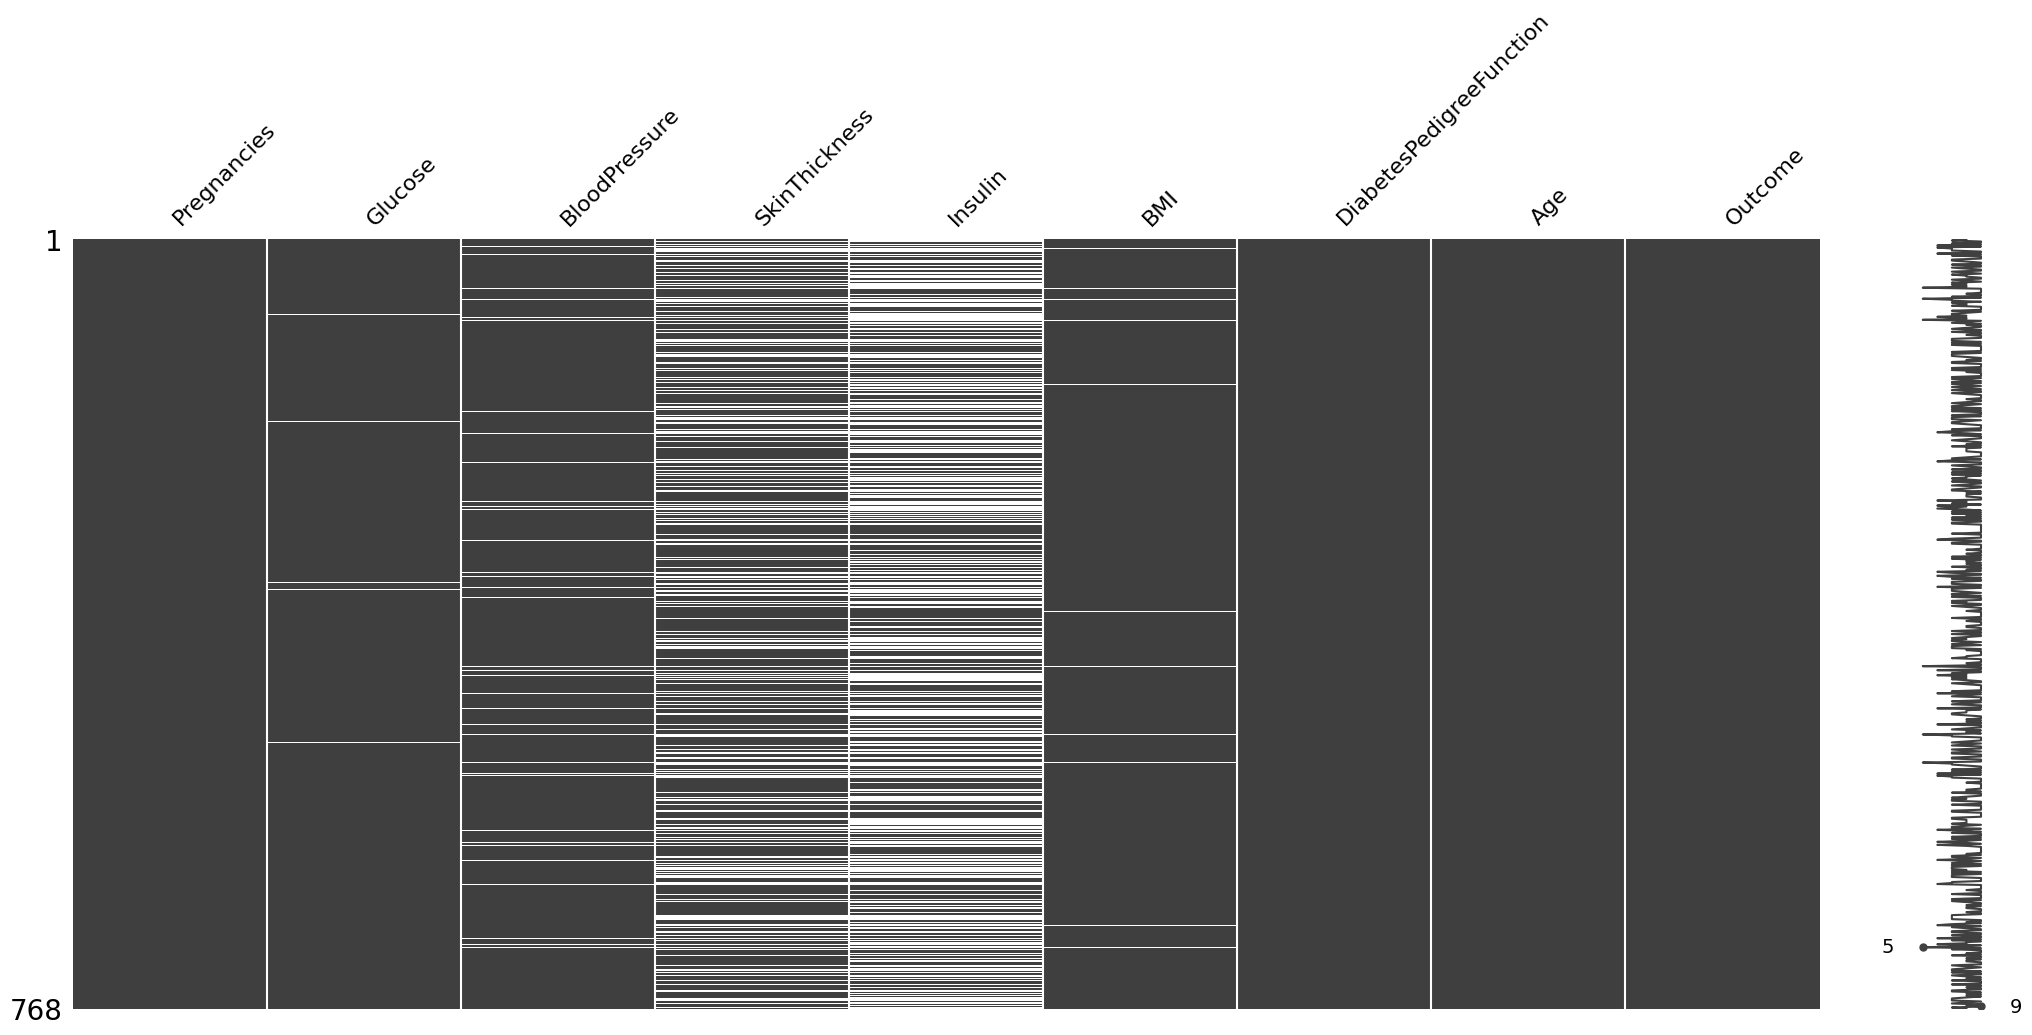

In [76]:
missing_values = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
data[missing_values] = np.where(data[missing_values] == 0, np.nan, data[missing_values])
msno.matrix(data)

In [77]:
def missing_percentage(data):
    total = data.isnull().sum().sort_values(ascending = False)[data.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)[round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(data)

,Total,Percent
Insulin,374,48.70
SkinThickness,227,29.56
BloodPressure,35,4.56
BMI,11,1.43
Glucose,5,0.65


In [78]:
data.isnull()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False
2,False,False,False,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
763,False,False,False,False,False,False,False,False,False
764,False,False,False,False,True,False,False,False,False
765,False,False,False,False,False,False,False,False,False
766,False,False,False,True,True,False,False,False,False


In [79]:
data.fillna(data.mean(), inplace=True)

In [80]:
data = data.round(0)

In [81]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,156.0,34.0,1.0,50,1
1,1,85.0,66.0,29.0,156.0,27.0,0.0,31,0
2,8,183.0,64.0,29.0,156.0,23.0,1.0,32,1
3,1,89.0,66.0,23.0,94.0,28.0,0.0,21,0
4,0,137.0,40.0,35.0,168.0,43.0,2.0,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,33.0,0.0,63,0
764,2,122.0,70.0,27.0,156.0,37.0,0.0,27,0
765,5,121.0,72.0,23.0,112.0,26.0,0.0,30,0
766,1,126.0,60.0,29.0,156.0,30.0,0.0,47,1


In [82]:
correlation = data.corr()
print(correlation)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.127891       0.208615       0.081770   
Glucose                      0.127891  1.000000       0.218530       0.192690   
BloodPressure                0.208615  0.218530       1.000000       0.191892   
SkinThickness                0.081770  0.192690       0.191892       1.000000   
Insulin                      0.056479  0.420052       0.072906       0.158134   
BMI                          0.024186  0.230835       0.279443       0.544493   
DiabetesPedigreeFunction    -0.023148  0.109569      -0.020062       0.082819   
Age                          0.544341  0.266507       0.324915       0.126107   
Outcome                      0.221898  0.492935       0.165723       0.214873   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies               0.056479  0.024186                 -0.023148   
Glucose                   0.420052  0.230

In [83]:

## Creating the varibles x and y
## X contains the independent varibles
## Y contains the dependent variables

X = data.drop("Outcome", axis=1)
Y = data['Outcome']

##split'n the data
X_train, X_test,Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [84]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [1800]
max_features = ['sqrt', 'log2']

In [85]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [86]:
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [87]:
best_model = grid_search.fit(X_train, Y_train)

In [88]:
rf_pred=best_model.predict(X_test)

In [89]:
accuracy = accuracy_score(rf_pred,Y_test)
print(accuracy)

0.7727272727272727


In [91]:
import pickle
pickle.dump(best_model, open('model.pkl','wb'))